In [1]:
## Cullan's code: only using Pgg info
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, Fish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

if __name__ == "__main__":

    configpath = os.path.join(parent, "test.ini")
    pardict = ConfigObj(configpath)

    # resolve inputfile relative to the ini file location
    ini_dir = os.path.dirname(configpath)
    inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
    pardict["inputfile"] = os.path.abspath(inputfile_path)

    #pardict = ConfigObj(configpath)

    # Read in the file containing the redshift bins, nz and bias values
    data = InputData(pardict)

    # Set up the linear power spectrum and derived parameters based on the input cosmology
    cosmo = CosmoResults(pardict, data.zmin, data.zmax)
    if np.any(data.volume > 0):
        cosmo.volume = data.volume * 1.0e9

    # Convert the nz to nbar in (h/Mpc)^3
    data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

    # Scales the bias so that it goes as b/G(z)
    if pardict.as_bool("scale_bias"):
        data.scale_bias(cosmo.growth)
    print("#  Data nbar")
    print(data.nbar, data.nbarz)
    print("#  Data bias")
    print(data.bias)

    # Precompute some things we might need for the Fisher matrix
    recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
    print("#  Data recon factor")
    print(recon)

    # Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
    identity = np.eye(len(data.nbar) + 3)
    print(
        "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
    )
    erralpha = np.zeros(len(cosmo.z))
    FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
    for iz in range(len(cosmo.z)):

        if np.any(data.nz[:, iz] > 1.0e-30):

            Catch = Fish(
                cosmo,
                cosmo.kmin,
                cosmo.kmax,
                data,
                iz,
                recon[iz],
                derPalpha,
                pardict.as_bool("BAO_only"),
                pardict.as_bool("GoFast"),
            )

            # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
            ExtraCatch = Fish(
                cosmo,
                cosmo.kmax,
                0.5,
                data,
                iz,
                recon[iz],
                derPalpha_BAO_only,
                True,
                pardict.as_bool("GoFast"),
            )
            Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

            # Add the Fisher matrix to the full fisher matrix
            FullCatch[
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            ] += Catch[: len(data.nbar), : len(data.nbar)]
            FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
            FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
            FullCatch[-3:, -3:] += Catch[-3:, -3:]

            # Invert the Fisher matrix to get the parameter covariance matrix
            cov = dgesv(Catch, identity)[2]

            # Compute the error on isotropic alpha also
            J = np.array([2.0 / 3.0, 1.0 / 3.0])
            erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

            # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
            means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
            cov_renorm = CovRenorm(cov, means)

            # Print the parameter means and errors
            errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
            print(
                " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
                #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
            )

            # Output the fisher matrix for the redshift bin
            write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

        else:
            erralpha[iz] = 1.0e30
            print(
                " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
            )

    # Run the cosmological parameters at the centre of the combined redshift bin
    identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
    cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

    # Invert the Combined Fisher matrix to get the parameter
    # covariance matrix and compute means and errors
    cov = dgesv(FullCatch, identity)[2]
    J = np.array([2.0 / 3.0, 1.0 / 3.0])
    erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
    means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
    cov_renorm = CovRenorm(cov, means)
    errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
    print("#  Combined errors")
    print("#=================")
    print(
        " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
            cosmo.z[0],
            cosmo.volume[0] / 1e9,
            means[0],
            errs[0],
            means[1],
            errs[1],
            means[2],
            errs[2],
            erralpha,
        )
    )
FullCatch1=FullCatch
# using BAO_ONLY=TRUE: changes results!!!


/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[168.50938544  24.27065415   9.02467497   4.67859971   2.86540256
    1.93963013   1.40359143   1.06531279   0.83802389   0.67784486]] [[1.71042498e+02 8.03110090e+00 3.13500904e+00 1.05560912e+00
  3.99565464e-01 1.89199801e-01 1.09116825e-01 7.41708986e-02
  4.82303734e-02 3.09844403e-02]]
#  Data bias
[[1.34353032 1.3506268  1.35777063 1.36496127 1.37219819 1.37948082
  1.38680864 1.39418108 1.40159762 1.40905771]]
#  Data recon factor
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
 0.005    0.0000     0.430       989.13         22.1       205.51        67.5       429.02       152.564
 0.015    0.0003     0.432       373.32         65.5       77.71        67.8       162.45       57.733
 0.025    0.0007     0.435       226.43         107.9       47.21        68.2       98.83       35.102
 0.035    0.0014     0.437       162.20         149.2       33.87        68.5       70.9

In [2]:
#My code: using all three power spectra
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, newFish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

if __name__ == "__main__":


    configpath = os.path.join(parent, "test.ini")
    pardict = ConfigObj(configpath)

    # resolve inputfile relative to the ini file location
    ini_dir = os.path.dirname(configpath)
    inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
    pardict["inputfile"] = os.path.abspath(inputfile_path)

    #pardict = ConfigObj(configpath)

    # Read in the file containing the redshift bins, nz and bias values
    data = InputData(pardict)

    # Set up the linear power spectrum and derived parameters based on the input cosmology
    cosmo = CosmoResults(pardict, data.zmin, data.zmax)
    if np.any(data.volume > 0):
        cosmo.volume = data.volume * 1.0e9

    # Convert the nz to nbar in (h/Mpc)^3
    data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

    # Scales the bias so that it goes as b/G(z)
    if pardict.as_bool("scale_bias"):
        data.scale_bias(cosmo.growth)
    print("#  Data nbar")
    print(data.nbar, data.nbarz)
    print("#  Data bias")
    print(data.bias)

    # Precompute some things we might need for the Fisher matrix
    recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
    print("#  Data recon factor")
    print(recon)

    # Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
    identity = np.eye(len(data.nbar) + 3)
    print(
        "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
    )
    erralpha = np.zeros(len(cosmo.z))
    FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
    for iz in range(len(cosmo.z)):

        if np.any(data.nz[:, iz] > 1.0e-30):

            Catch = newFish(
                cosmo,
                cosmo.kmin,
                cosmo.kmax,
                data,
                iz,
                recon[iz],
                derPalpha,
                pardict.as_bool("BAO_only"),
                pardict.as_bool("GoFast"),
            )

            # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
            ExtraCatch = newFish(
                cosmo,
                cosmo.kmax,
                0.5,
                data,
                iz,
                recon[iz],
                derPalpha_BAO_only,
                True,
                pardict.as_bool("GoFast"),
            )
            Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

            # Add the Fisher matrix to the full fisher matrix
            FullCatch[
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            ] += Catch[: len(data.nbar), : len(data.nbar)]
            FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
            FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
            FullCatch[-3:, -3:] += Catch[-3:, -3:]

            # Invert the Fisher matrix to get the parameter covariance matrix
            cov = dgesv(Catch, identity)[2]

            # Compute the error on isotropic alpha also
            J = np.array([2.0 / 3.0, 1.0 / 3.0])
            erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

            # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
            means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
            cov_renorm = CovRenorm(cov, means)

            # Print the parameter means and errors
            errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
            print(
                " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
                #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
            )

            # Output the fisher matrix for the redshift bin
            write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

        else:
            erralpha[iz] = 1.0e30
            print(
                " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
            )

    # Run the cosmological parameters at the centre of the combined redshift bin
    identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
    cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

    # Invert the Combined Fisher matrix to get the parameter
    # covariance matrix and compute means and errors
    cov = dgesv(FullCatch, identity)[2]
    J = np.array([2.0 / 3.0, 1.0 / 3.0])
    erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
    means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
    cov_renorm = CovRenorm(cov, means)
    errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
    print("#  Combined errors")
    print("#=================")
    print(
        " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
            cosmo.z[0],
            cosmo.volume[0] / 1e9,
            means[0],
            errs[0],
            means[1],
            errs[1],
            means[2],
            errs[2],
            erralpha,
        )
    )
# using BAO_ONLY=TRUE: changes results!!!\
# plot changes and see if it fits the data

/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[168.50938544  24.27065415   9.02467497   4.67859971   2.86540256
    1.93963013   1.40359143   1.06531279   0.83802389   0.67784486]] [[1.71042498e+02 8.03110090e+00 3.13500904e+00 1.05560912e+00
  3.99565464e-01 1.89199801e-01 1.09116825e-01 7.41708986e-02
  4.82303734e-02 3.09844403e-02]]
#  Data bias
[[1.34353032 1.3506268  1.35777063 1.36496127 1.37219819 1.37948082
  1.38680864 1.39418108 1.40159762 1.40905771]]
#  Data recon factor
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
 0.005    0.0000     0.430       95.19         22.1       0.00        67.5       0.00       0.001
 0.015    0.0003     0.432       36.11         65.5       0.05        67.8       0.02       0.029
 0.025    0.0007     0.435       22.02         107.9       0.19        68.2       0.09       0.112
 0.035    0.0014     0.437       15.88         149.2       0.73        68.5       0.34       0.430
 0.04

In [3]:
from TackleBox import get_powerfx, get_inv_cov,get_inv_cov_un, compute_inv_cov,get_full_deriv,compute_deriv_alphas
from scipy.interpolate import splrep, splev
kvec = np.linspace(cosmo.kmin,cosmo.kmax,400)
muvec = np.linspace(0,1,100)
pgg=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgg at each k and mu value
pgu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgu at each k and mu value
puu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of puu at each k and mu value
cov=np.zeros((3,3,len(kvec),len(muvec))) # covariance info, 3x3 for Pgg Pgu Puu and then k and mu
invcov=np.zeros((3,3,len(kvec),len(muvec))) # inverse covariance info
bder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt b at each k and mu value
fder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt f at each k and mu value
aperder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt aperp at each k and mu value
aparder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt apara at each k and mu value

In [4]:
pkval = splev(kvec, cosmo.pk[0])
pksmoothval = splev(kvec, cosmo.pksmooth[0])
npop = np.shape(data.nbar)[0]
npk = int(npop*(npop+1)/2)
coords = [[kval, muval] for kval in kvec for muval in muvec]
kaiser = np.tile(data.bias[:, 0], (len(muvec), 1)).T + cosmo.f[0] * muvec ** 2
derPalpha = compute_deriv_alphas(cosmo,BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = np.array([
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[0] / cosmo.sigma8[0]) ** 2
for i in range(2)
])

In [13]:
fval,zval,hval,nbarval,vbarval,pverr,vol,dk,da,sigmaval=cosmo.f[0],cosmo.z[0],cosmo.h[0],data.nbar[0,0],data.nbarz[0,0],data.pverr[0,0],cosmo.volume[0],kvec[1]-kvec[0],cosmo.da[0],cosmo.sigma8[0]
for i, kval in enumerate(kvec):
    for j, muval in enumerate(muvec):
        pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[:,j],fval,zval,hval)
        cov[:,:,i,j],invcov[:,:,i,j]=get_inv_cov(pgg[i,j],pgu[i,j],puu[i,j],nbarval,vbarval,pverr,kval,vol,da,hval,dk)
        info=get_full_deriv(kval,muval,pkval[i],pksmoothval[i],kaiser[:,j],fval,zval,hval,derPalphaval[:,i,j],sigmaval) # then multiply by Dfactor**2 -> same for 4, different for power spec, make them the same for now.
        bder[:,i,j],fder[:,i,j],aperder[:,i,j],aparder[:,i,j]=info[:,0],info[:,1],info[:,2],info[:,3]

/tmp/ipykernel_423505/363731055.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[:,j],fval,zval,hval)


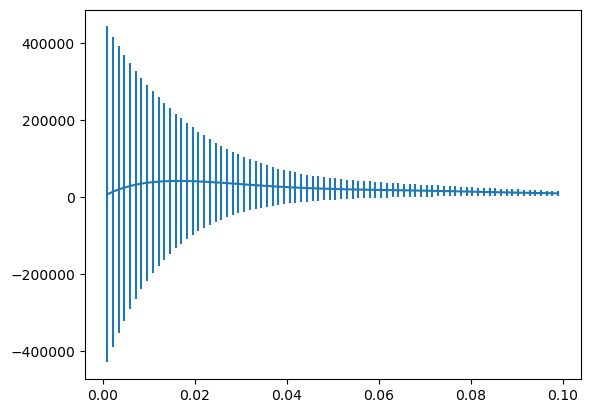

In [28]:
import matplotlib.pyplot as plt
p=3
factor=(2*np.pi**2)/(vol*kvec**2*dk)
plt.errorbar(kvec[::5],(pgg[:,p])[::5],yerr=(np.sqrt(cov[0,0,:,p]))[::5])
plt.show()

In [23]:
print(factor[::5])
print(factor[::5]/dk)
print(dk)

[5.54390234e-01 1.10429810e-01 4.57463945e-02 2.48656357e-02
 1.55945368e-02 1.06853274e-02 7.77605531e-03 5.91135617e-03
 4.64502039e-03 3.74594864e-03 3.08472297e-03 2.58428822e-03
 2.19644260e-03 1.88978072e-03 1.64312998e-03 1.44179554e-03
 1.27531983e-03 1.13609663e-03 1.01848656e-03 9.18236935e-04
 8.32091808e-04 7.57524242e-04 6.92548857e-04 6.35588302e-04
 5.85376608e-04 5.40888240e-04 5.01285306e-04 4.65877820e-04
 4.34093442e-04 4.05454201e-04 3.79558423e-04 3.56066570e-04
 3.34690048e-04 3.15182309e-04 2.97331705e-04 2.80955721e-04
 2.65896298e-04 2.52015999e-04 2.39194864e-04 2.27327808e-04
 2.16322466e-04 2.06097381e-04 1.96580502e-04 1.87707906e-04
 1.79422722e-04 1.71674218e-04 1.64417024e-04 1.57610465e-04
 1.51217988e-04 1.45206675e-04 1.39546813e-04 1.34211530e-04
 1.29176474e-04 1.24419534e-04 1.19920600e-04 1.15661343e-04
 1.11625038e-04 1.07796390e-04 1.04161396e-04 1.00707212e-04
 9.74220421e-05 9.42950376e-05 9.13162056e-05 8.84763302e-05
 8.57669013e-05 8.318005

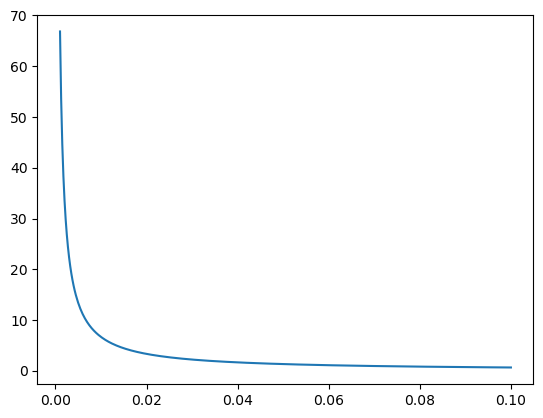

In [ ]:

#plt.plot(kvec,(np.sqrt(cov[2,2,:,p])/puu[:,p]))
#plt.show()
plt.plot(kvec,(np.sqrt(cov[0,0,:,p]))/pgg[:,p])
plt.show()

In [ ]:
k=60
plt.plot(kvec,bder[1,:,k]/pgu[:,k],label='b$\sigma_8$')
plt.plot(kvec,fder[1,:,k]/pgu[:,k],label='f$\sigma_8$')
plt.plot(kvec,aperder[1,:,k]/pgu[:,k],label='$\\alpha_{\perp}$')
plt.plot(kvec,aparder[1,:,k]/pgu[:,k],label='$\\alpha_{\parallel}$')
plt.ylabel('$\\frac{1}{P_{gu}}$  $\\frac{dP_{gu}}{d\\theta_i}$')
plt.xlabel('k (h Mpc$^{-1}$)')
plt.title('Derivatives of $P_{{gu}}$ at $\mu$={:.2f}'.format(muvec[k]))
plt.legend()
path = '../Figures/DerivativesExample.png'
plt.savefig(path, dpi=300)
plt.close()

In [14]:
for i in range(100):
    plt.errorbar(kvec[::5],(pgu[:,i]*kvec)[::5],yerr=(np.sqrt(cov[1,1,:,i])*kvec)[::5])
    plt.title('P$_{{gu}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))
    plt.ylabel('$P_{gu}k$')
    plt.xlabel('k (h Mpc$^{-1})$')
    plt.ylim(-10000,3.5e7)
    path = '../../Data/Pgu/{:03d}.png'.format(i)
    plt.savefig(path, dpi=300)
    plt.close()

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_419332/788185335.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title('P$_{{gu}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))


In [15]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Pgu"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Pgu moving errorbars.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)